In [1]:
import json
from pathlib import Path
import jsonlines
from allennlp.data.vocabulary import Vocabulary
from allennlp.models.archival import load_archive
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import torch
from allennlp.common.util import import_module_and_submodules
from allennlp.predictors.predictor import Predictor, JsonDict
import sys
sys.path.append("../")
import logging
from typing import List
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from box_embeddings.parameterizations.box_tensor import BoxTensor
%matplotlib notebook

In [2]:
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", level=logging.INFO)

In [3]:
path_dic = {
    'Typenet_Vector_Old': Path('../wandb/run-20200926_143123-wrr3p3bx/files/training_dumps'),
    'Typenet_Vector': Path('../wandb/run-20201030_190955-2wvf35nx/files/training_dumps'), 
    'Typenet_Box': Path('../wandb/run-20201004_010247-3uun86fl/files/training_dumps') ,
    'Typenet_Gumbel': Path('../wandb/run-20201111_144539-61juf3x4/files/training_dumps'),
    'Blurb_Vector': Path('../wandb/run-20201030_222315-2q541dtj/files/training_dumps'),
    'Blurb_Box': Path('../wandb/run-20201030_224257-3lc55qcw/files/training_dumps'),
    'Blurb_Gumbel': Path('../wandb/run-20201112_134640-wcrz6yax/files/training_dumps')
}

In [4]:
blurb = 'Blurb'
typenet = 'Typenet'
env = 'local' #local or 'gypsum'
dataset = blurb
keyword = 'Gumbel' #Vector or Box or Gumbel

In [5]:
model_path = path_dic[f"{dataset}_{keyword}"]/'model.tar.gz'
vocab_file = path_dic[f"{dataset}_{keyword}"]/'vocabulary'

In [6]:
vocab = Vocabulary.from_files(vocab_file)
all_labels = np.asarray(list(vocab.get_token_to_index_vocabulary('labels').keys()))

2020-11-13 10:15:14,078 - INFO - allennlp.data.vocabulary - Loading token dictionary from ../wandb/run-20201112_134640-wcrz6yax/files/training_dumps/vocabulary.
2020-11-13 10:15:14,080 - INFO - filelock - Lock 5205555688 acquired on ../wandb/run-20201112_134640-wcrz6yax/files/training_dumps/vocabulary/.lock
2020-11-13 10:15:14,368 - INFO - filelock - Lock 5205555688 released on ../wandb/run-20201112_134640-wcrz6yax/files/training_dumps/vocabulary/.lock


In [7]:
import_module_and_submodules("multilabel_learning")

In [10]:
override_dict = {
    'model': {'visualization_mode': True}}
if dataset == typenet:
    override_dict['validation_dataset_reader'] = {'cache_directory': None}
    override_dict['validation_data_path'] ='../.data/typenet/'+('sample_' if env == 'local' else '') + 'dev_bags.json'
elif dataset == blurb:
    override_dict['validation_data_path'] ='../.data/blurb_genre_collection/'+('sample_' if env == 'local' else '') + 'dev.json'
override_dict

{'model': {'visualization_mode': True},
 'validation_data_path': '../.data/blurb_genre_collection/sample_dev.json'}

In [11]:
# Step 1: Load the model
archive = load_archive(
    model_path,
    overrides = json.dumps(override_dict)
)
# Step 2: Get the predictor
predictor = Predictor.from_archive(
        archive, 
        #args.predictor, 
        dataset_reader_to_load="validation",
        frozen = True
    )

2020-11-13 10:20:26,011 - INFO - allennlp.models.archival - loading archive file ../wandb/run-20201112_134640-wcrz6yax/files/training_dumps/model.tar.gz from cache at ../wandb/run-20201112_134640-wcrz6yax/files/training_dumps/model.tar.gz
2020-11-13 10:20:26,017 - INFO - allennlp.models.archival - extracting archive file ../wandb/run-20201112_134640-wcrz6yax/files/training_dumps/model.tar.gz to temp dir /var/folders/r2/8mbb22091rb4vq4xtd19bbw80000gn/T/tmp723qct9d
2020-11-13 10:20:29,104 - INFO - allennlp.common.params - type = from_instances
2020-11-13 10:20:29,105 - INFO - allennlp.data.vocabulary - Loading token dictionary from /var/folders/r2/8mbb22091rb4vq4xtd19bbw80000gn/T/tmp723qct9d/vocabulary.
2020-11-13 10:20:29,106 - INFO - filelock - Lock 5678543200 acquired on /var/folders/r2/8mbb22091rb4vq4xtd19bbw80000gn/T/tmp723qct9d/vocabulary/.lock
2020-11-13 10:20:29,395 - INFO - filelock - Lock 5678543200 released on /var/folders/r2/8mbb22091rb4vq4xtd19bbw80000gn/T/tmp723qct9d/vocabu

2020-11-13 10:20:30,083 - INFO - allennlp.common.params - model.label_embeddings.box_factory.type = box_factory
2020-11-13 10:20:30,084 - INFO - allennlp.common.params - model.label_embeddings.box_factory.name = mindelta_from_vector
2020-11-13 10:20:30,104 - INFO - allennlp.common.params - model.label_embeddings.box_initializer.type = uniform-box-initializer
2020-11-13 10:20:30,105 - INFO - allennlp.common.params - model.label_embeddings.box_initializer.dimensions = 150
2020-11-13 10:20:30,108 - INFO - allennlp.common.params - model.label_embeddings.box_initializer.box_type_factory.type = box_factory
2020-11-13 10:20:30,110 - INFO - allennlp.common.params - model.label_embeddings.box_initializer.box_type_factory.name = mindelta_from_vector
2020-11-13 10:20:30,113 - INFO - allennlp.common.params - model.label_embeddings.box_initializer.num_boxes = None
2020-11-13 10:20:30,114 - INFO - allennlp.common.params - model.label_embeddings.box_initializer.minimum = -1
2020-11-13 10:20:30,114 - 

In [12]:
# Step 3: Get instance Data
data = list(predictor._dataset_reader.read(override_dict['validation_data_path']))
output_dicts = []
z = []
Z = []
for x in data:
    r = predictor.predict_instance(x)
    for y_z in r['y_boxes_z']:
        z.append(y_z)
    for y_Z in r['y_boxes_Z']:
        Z.append(y_Z)
    z.append(r['x_boxes_z'])
    Z.append(r['x_boxes_Z'])
    output_dicts.append(r)


../multilabel_learning/models/multi_instance_typing_box_model.py:323: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)
  for sample_number in range(batch_size)


In [13]:
z_min = np.min(np.array(z))
z_max = np.max(np.array(Z))

In [14]:
len(output_dicts)

739

In [15]:
def box_dimension_intersection(x_z, x_Z, y_z, y_Z):
    boxes_x = []
    boxes_y = []
    conditionals_y_x = []
    conditionals_x_y = []
    for i in range(x_z.shape[0]):
        boxes_x.append(BoxTensor.from_zZ(torch.tensor([x_z[i]]), torch.tensor([x_Z[i]])))
        boxes_y.append(BoxTensor.from_zZ(torch.tensor([y_z[i]]), torch.tensor([y_Z[i]])))
    print('Boxes created')
    for x_box in boxes_x:
        temp_y_x = []
        temp_x_y = []
        for y_box in boxes_y:
            #breakpoint()
            inter = predictor._model._volume(predictor._model._intersect(x_box, y_box))
            temp_x_y.append((inter-predictor._model._volume(y_box)).item())
            temp_y_x.append((inter-predictor._model._volume(x_box)).item())
        conditionals_x_y.append(temp_x_y)
        conditionals_y_x.append(temp_y_x)
    return np.array(conditionals_y_x), np.array(conditionals_x_y)
            

In [16]:
y_z, y_Z = np.array(output_dicts[0]['y_boxes_z'][0]), np.array(output_dicts[0]['y_boxes_Z'][0])
x_z, x_Z = np.array(output_dicts[0]['x_boxes_z']), np.array(output_dicts[0]['x_boxes_Z'])   
pyx, pxy = box_dimension_intersection(x_z,x_Z, y_z, y_Z)

Boxes created


In [19]:
def plot_dimension_interval(ax, dim_: int, x_box: List[float], y_box:List[float], y_color='orange', x_color='blue', label=False):
    if not label:
        ax.hlines(dim_, x_box[0], x_box[1], x_color, lw=6)
        ax.hlines(dim_, y_box[0], y_box[1], y_color, lw=3)
    else:
        ax.hlines(dim_, x_box[0], x_box[1], x_color, lw=6, label = 'X Box Intervals')
        ax.hlines(dim_, y_box[0], y_box[1], y_color, lw=3, label = 'Y Box Intervals')
    
def plot_x_and_y_box(axs, prob_y_x, x_z, x_Z, y_z, y_Z):
    
    for dim_ in range(y_z.shape[0]):
        p = dim_%6
        plot_dimension_interval(axs[p][0], dim_, [x_z[dim_], x_Z[dim_]], [y_z[dim_], y_Z[dim_]],label=(dim_==0))
        if dim_ == 0:
            #axs[p][1].hlines(dim_, -1, prob_y_x[dim_][dim_], 'red', lw=3, label = 'P(Y_d|X_d)')
            axs[p][1].scatter([np.exp(prob_y_x[dim_][dim_])], [dim_],  c='r', label='P(Y_d|X_d)')
        else:
            #axs[p][1].hlines(dim_, -1, prob_y_x[dim_][dim_], 'red', lw=3)
            axs[p][1].scatter( [np.exp(prob_y_x[dim_][dim_])],[dim_], c='r')
    for i in range(axs.shape[0]):
        axs[i][0].yaxis.set_ticklabels([])
        axs[i][1].yaxis.set_ticklabels([])
    axs[0][0].legend(bbox_to_anchor=(0.5,1.3),loc="upper center")
    axs[0][1].legend(bbox_to_anchor=(0.8,1.3),loc="upper center")
        
def x_event_handler(obj):
    # Step 4: Get prediction boxes
    output_dict = predictor.predict_instance(data[obj.new])
    print(output_dict['meta'].keys())
    if dataset == typenet:
        true_labels = set(output_dict['meta']['types']+output_dict['meta']['types_extra'])
    elif dataset == blurb:
        true_labels = []
        for value in output_dict['meta']['topics'].values():
            true_labels+= [value] if not isinstance(value, list) else value
    print(f'True Labels: {true_labels}')
    ordered_scores_ind = np.argsort(-1*np.asarray(output_dict['positive_probs']))
    y_dropdown = widgets.Dropdown(
        options = ['None'] + list(all_labels[ordered_scores_ind]),
        description='Choose Y :',
    )
    display(y_dropdown)
    fig, axs = plt.subplots(3,4, figsize=(8,10))
    axs = axs.reshape(6,2)
        
    def y_event_handler(y_value):
        for ax in axs.reshape(-1):
            ax.clear()
        for ax in axs:
            ax[1].set_xlim(0,1)
            ax[0].set_xlim(z_min, z_max)
        idx = vocab.get_token_index(y_value.new, namespace='labels')
        y_z, y_Z = np.array(output_dict['y_boxes_z'][idx]), np.array(output_dict['y_boxes_Z'][idx])
        x_z, x_Z = np.array(output_dict['x_boxes_z']), np.array(output_dict['x_boxes_Z'])
        print('x_z', x_z)
        print('y_z', y_z)
        print('Length:', x_Z-x_z)
        prob_y_x, prob_x_y = box_dimension_intersection(x_z, x_Z, y_z, y_Z)
        # Step 5: Plot y boxes all dimensions
        plot_x_and_y_box(axs, prob_y_x, x_z, x_Z, y_z, y_Z)
        
        
    y_dropdown.observe(y_event_handler, names='value')
    

Dropdown(description='Choose X :', options=(None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…

dict_keys(['title', 'body', 'topics', 'idx', 'using_tc'])
True Labels: ['Fiction', 'Western Fiction']


Dropdown(description='Choose Y :', options=('None', 'Fiction', 'Western Fiction', 'Historical Fiction', 'Graph…

<IPython.core.display.Javascript object>


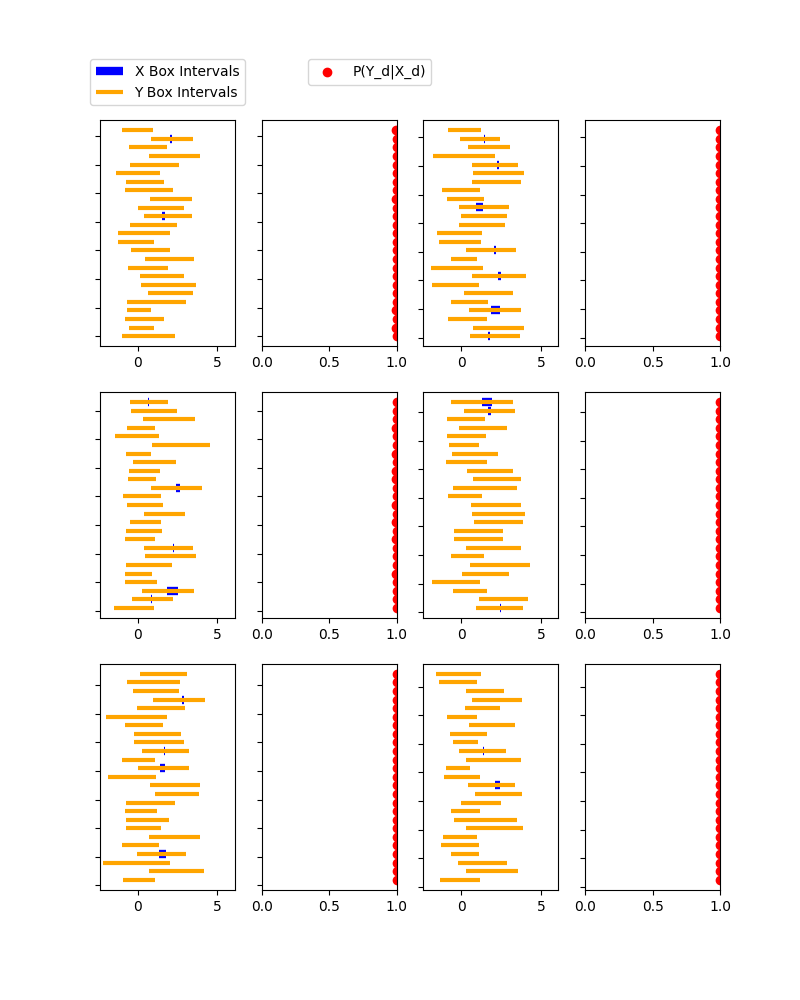

x_z [ 7.47286439e-01  1.68614125e+00 -3.56788546e-01  2.42899442e+00
  7.07114339e-02 -1.90636694e-01  3.33619803e-01  1.90573931e+00
  8.62384558e-01  2.40237570e+00  2.61715317e+00  2.17836833e+00
  5.18602192e-01  3.26009512e-01  1.85021520e+00  4.29197341e-01
 -1.13386661e-03  1.44707096e+00  4.40002680e-01  1.85496700e+00
  2.08228469e-01 -4.12771940e-01  1.33087158e+00  4.56489742e-01
  1.20746398e+00  5.69933295e-01  1.27366096e-01  1.34276187e+00
  3.42577338e-01 -8.75476152e-02  1.70491636e+00  1.84251857e+00
  8.02848279e-01  2.93533826e+00  2.54377913e+00  1.20268762e-02
  1.90992916e+00 -4.03969646e-01  2.02428246e+00  4.18849945e-01
  5.43817461e-01  2.40994096e+00  1.73510408e+00  2.33255577e+00
  2.20081711e+00  1.77215433e+00  1.05613601e+00  1.34394157e+00
  7.66411304e-01 -3.14756840e-01  3.05051923e-01  1.51723385e+00
  3.02975893e-01  3.93265814e-01  1.76710343e+00  1.72239572e-01
  4.63315487e-01  1.04789877e+00  7.52868652e-01  1.32709432e+00
  1.04461598e+00  2.0

x_z [ 7.47286439e-01  1.68614125e+00 -3.56788546e-01  2.42899442e+00
  7.07114339e-02 -1.90636694e-01  3.33619803e-01  1.90573931e+00
  8.62384558e-01  2.40237570e+00  2.61715317e+00  2.17836833e+00
  5.18602192e-01  3.26009512e-01  1.85021520e+00  4.29197341e-01
 -1.13386661e-03  1.44707096e+00  4.40002680e-01  1.85496700e+00
  2.08228469e-01 -4.12771940e-01  1.33087158e+00  4.56489742e-01
  1.20746398e+00  5.69933295e-01  1.27366096e-01  1.34276187e+00
  3.42577338e-01 -8.75476152e-02  1.70491636e+00  1.84251857e+00
  8.02848279e-01  2.93533826e+00  2.54377913e+00  1.20268762e-02
  1.90992916e+00 -4.03969646e-01  2.02428246e+00  4.18849945e-01
  5.43817461e-01  2.40994096e+00  1.73510408e+00  2.33255577e+00
  2.20081711e+00  1.77215433e+00  1.05613601e+00  1.34394157e+00
  7.66411304e-01 -3.14756840e-01  3.05051923e-01  1.51723385e+00
  3.02975893e-01  3.93265814e-01  1.76710343e+00  1.72239572e-01
  4.63315487e-01  1.04789877e+00  7.52868652e-01  1.32709432e+00
  1.04461598e+00  2.0

In [20]:
x_idx_dropdown = widgets.Dropdown(
    options = [None] + list(range(len(data))),
    description='Choose X :'
    
)
x_idx_dropdown.observe(x_event_handler, names='value')
display(x_idx_dropdown)

In [13]:
# Analysing weights of linear layers
layer = 1
weights = predictor._model._feedforward._linear_layers[layer].weight.detach().cpu().numpy()
weights.shape

(300, 600)

<IPython.core.display.Javascript object>


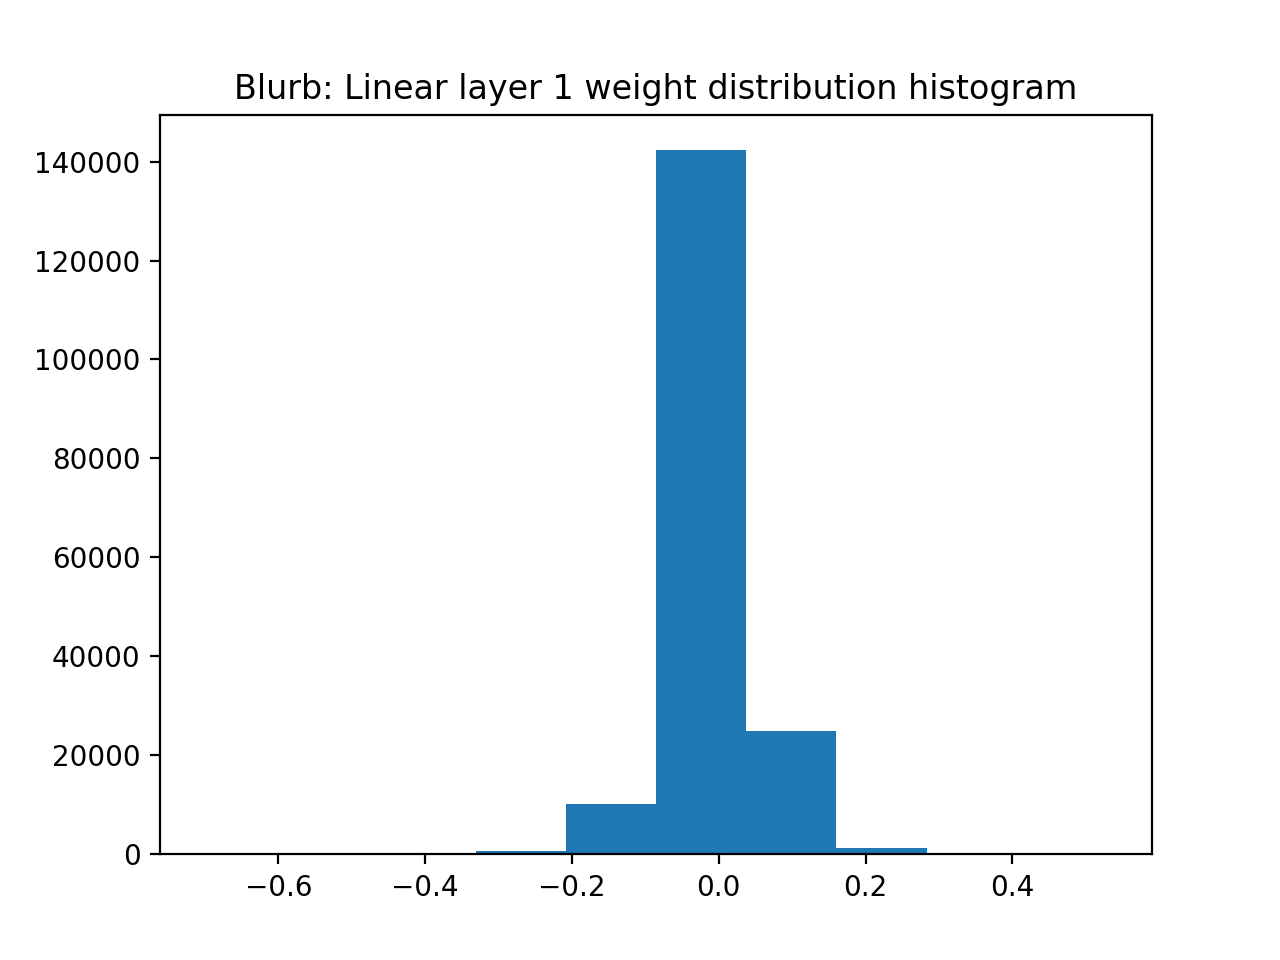

In [14]:
fig = plt.figure()
plt.clf()
plt.hist(weights.reshape(-1))
plt.title(f'{dataset}: Linear layer {layer} weight distribution histogram')
plt.savefig(f'./{dataset}_layer_{layer}_histogram.png')
plt.show()

<IPython.core.display.Javascript object>


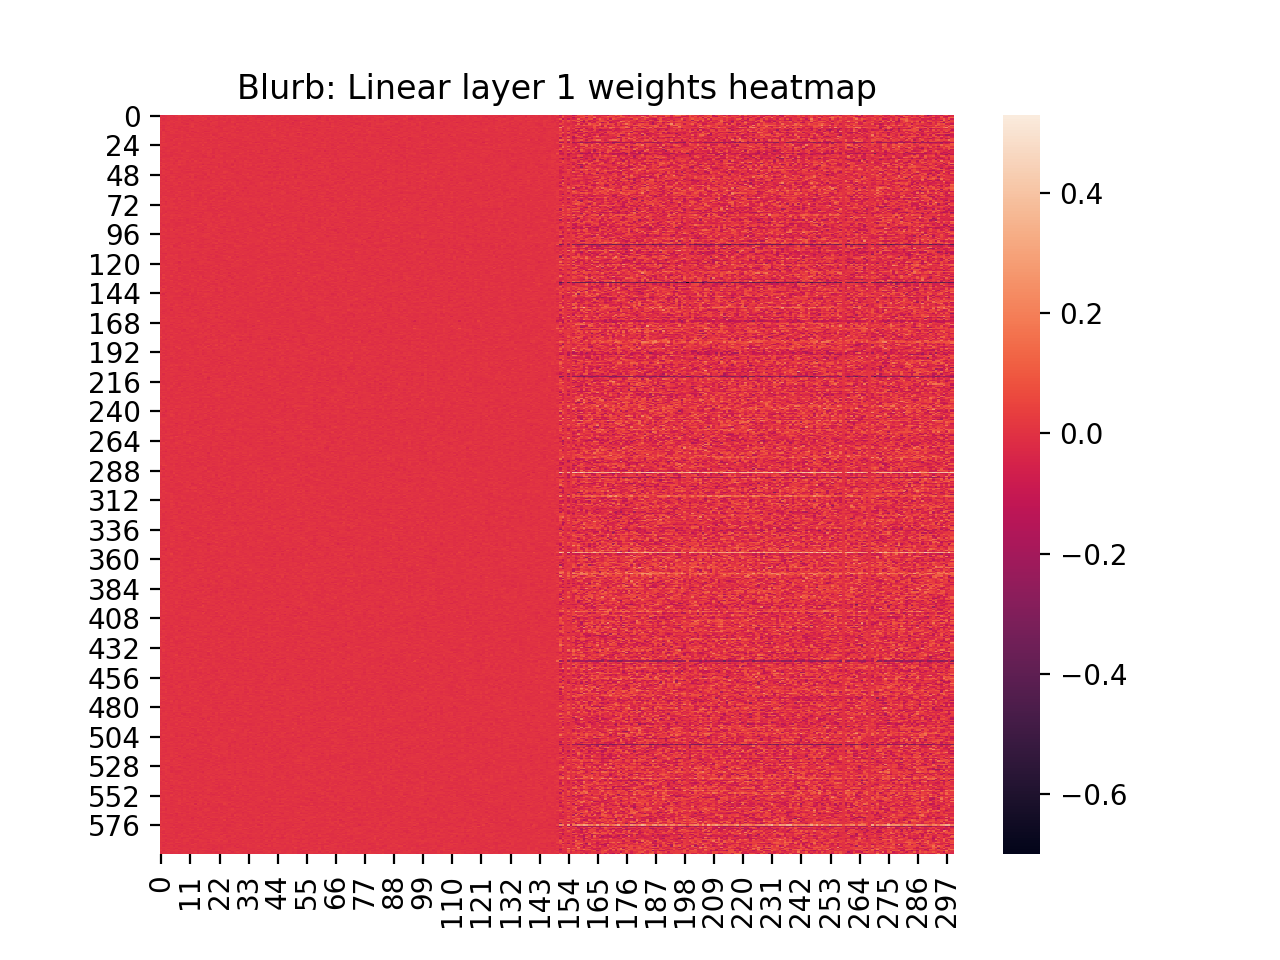

Text(0.5, 1.0, 'Blurb: Linear layer 1 weights heatmap')

In [15]:
f, ax = plt.subplots()
ax = sns.heatmap(weights.T)
plt.savefig(f'./{dataset}_Layer_{layer}_heatmap.png')
plt.title(f'{dataset}: Linear layer {layer} weights heatmap')